# Лабораторная работа 2

> =========================================
>
> Тема: Классификация, оченка точности классификации
>
> Набор данных: Данные владельцев кредитных карт
>
> Студент: Цветков Иван ИУ7-22М
> 
>=========================================

## 0. Импорты

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from kneed import KneeLocator
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

## 1. Данные

### 1.1. Чтение

In [171]:
pd.set_option('display.max_columns', None)

dfInit = pd.read_csv('./data/Credit_card.csv', delimiter=',', encoding='utf8')
del dfInit["Ind_ID"]


df = dfInit.copy(deep=True)

df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2
1544,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1
1545,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4
1546,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2


### 1.2. Преобразование

In [172]:
def updateData(fieldName):
  dataDf = list(set(df[fieldName].map(lambda elem: elem)))

  cnt = 0
  dataDict = {}
  for shape in dataDf:
    if shape not in dataDict.keys():
      dataDict[shape] = cnt
      cnt += 1
  print(f"{fieldName} = {dataDict}\n")

  df[fieldName] = df[fieldName].map(lambda elem: dataDict[elem])

In [173]:
df.dropna(axis=0, inplace=True)

del df["Mobile_phone"]
del df["Work_Phone"]
del df["Phone"]
del df["EMAIL_ID"]

updateData(fieldName="GENDER")
updateData(fieldName="Car_Owner")
updateData(fieldName="Propert_Owner")
updateData(fieldName="Type_Income")
updateData(fieldName="EDUCATION")
updateData(fieldName="Marital_status")
updateData(fieldName="Housing_type")
updateData(fieldName="Type_Occupation")

df


GENDER = {'F': 0, 'M': 1}

Car_Owner = {'N': 0, 'Y': 1}

Propert_Owner = {'N': 0, 'Y': 1}

Type_Income = {'Pensioner': 0, 'Working': 1, 'Commercial associate': 2, 'State servant': 3}

EDUCATION = {'Higher education': 0, 'Lower secondary': 1, 'Secondary / secondary special': 2, 'Incomplete higher': 3}

Marital_status = {'Single / not married': 0, 'Married': 1, 'Civil marriage': 2, 'Widow': 3, 'Separated': 4}

Housing_type = {'Office apartment': 0, 'Municipal apartment': 1, 'Rented apartment': 2, 'With parents': 3, 'House / apartment': 4, 'Co-op apartment': 5}

Type_Occupation = {'IT staff': 0, 'Drivers': 1, 'Low-skill Laborers': 2, 'Waiters/barmen staff': 3, 'Security staff': 4, 'Core staff': 5, 'Cooking staff': 6, 'Medicine staff': 7, 'Managers': 8, 'Realty agents': 9, 'Accountants': 10, 'Laborers': 11, 'HR staff': 12, 'Cleaning staff': 13, 'Private service staff': 14, 'Secretaries': 15, 'Sales staff': 16, 'High skill tech staff': 17}



,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Type_Occupation,Family_Members
8,1,1,1,1,450000.0,2,2,1,4,-18173.0,-678,5,3
9,1,1,1,1,450000.0,0,2,1,4,-18173.0,-678,5,3
10,1,1,1,1,450000.0,2,2,0,4,-18173.0,-678,5,1
11,0,1,1,0,90000.0,1,2,1,4,-18950.0,-1002,6,2
13,0,1,1,0,90000.0,1,2,1,4,-18950.0,-1002,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,0,1,1,1,144000.0,1,0,1,4,-12903.0,-2924,10,3
1542,1,1,0,1,360000.0,3,2,1,4,-11294.0,-3536,1,3
1544,0,0,0,0,225000.0,2,3,0,4,-10229.0,-1209,10,1
1545,1,1,1,2,180000.0,1,0,1,4,-13174.0,-2477,8,4


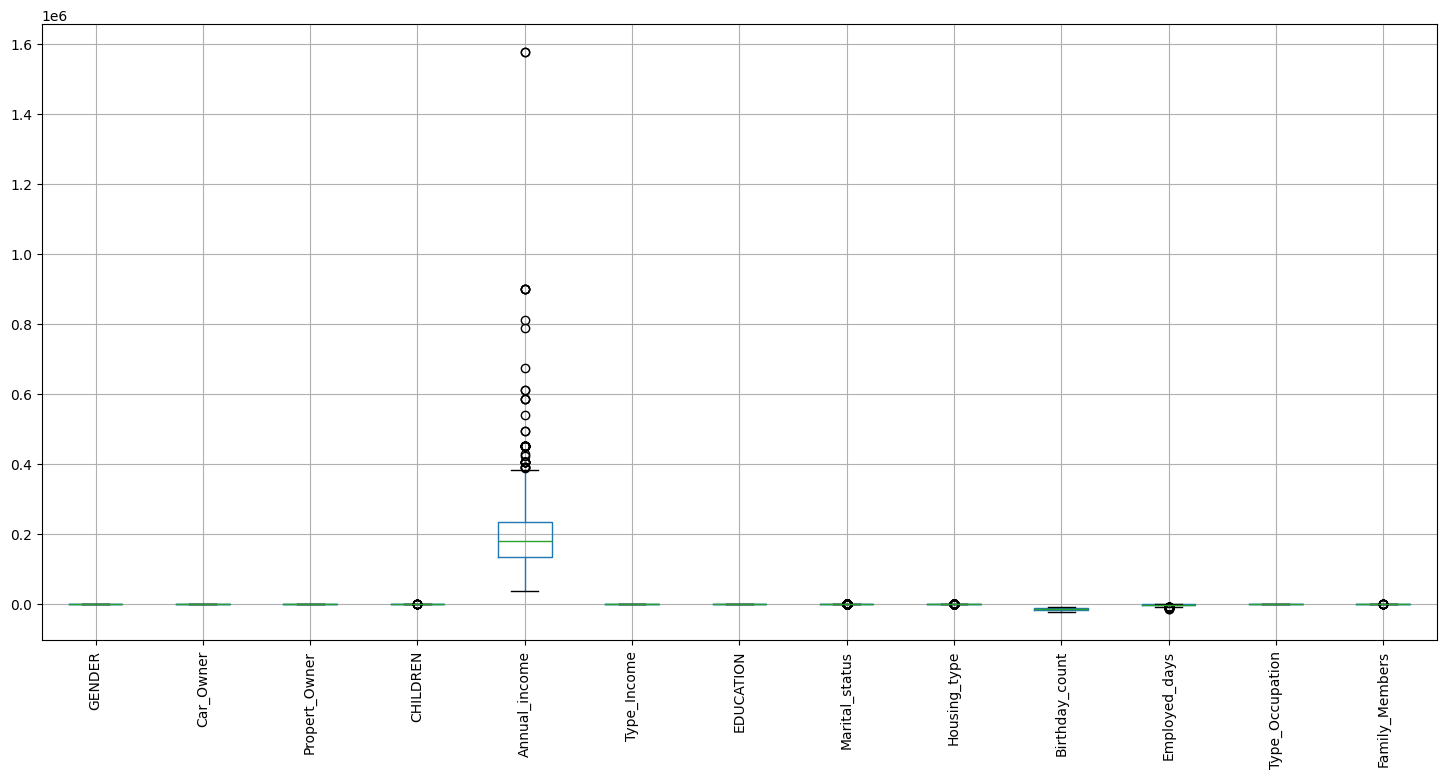

In [174]:
ax = df.boxplot(column=list(df.columns),figsize=(18,8))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

ax
plt.show()

## 2. Выполнение

### 2.1. Разделение на обучающие и тестовые данные

In [175]:
x = df.drop(["GENDER"], axis=1)
y = df["GENDER"]

In [176]:
xTraining, xTest, yTraining, yTest = train_test_split(x, y, test_size = 0.3, random_state=42)

In [177]:
scaler = StandardScaler()
scaler.fit(xTraining)
xTraining = scaler.transform(xTraining)
xTest = scaler.transform(xTest)

In [178]:
labelEncoder = preprocessing.LabelEncoder()
yTrainingEncoded = labelEncoder.fit_transform(yTraining)

### 2.2. k-ближайших соседей

In [179]:
import warnings
warnings.filterwarnings("ignore") # убрать FutureWarning (возникает в KMeans функции)

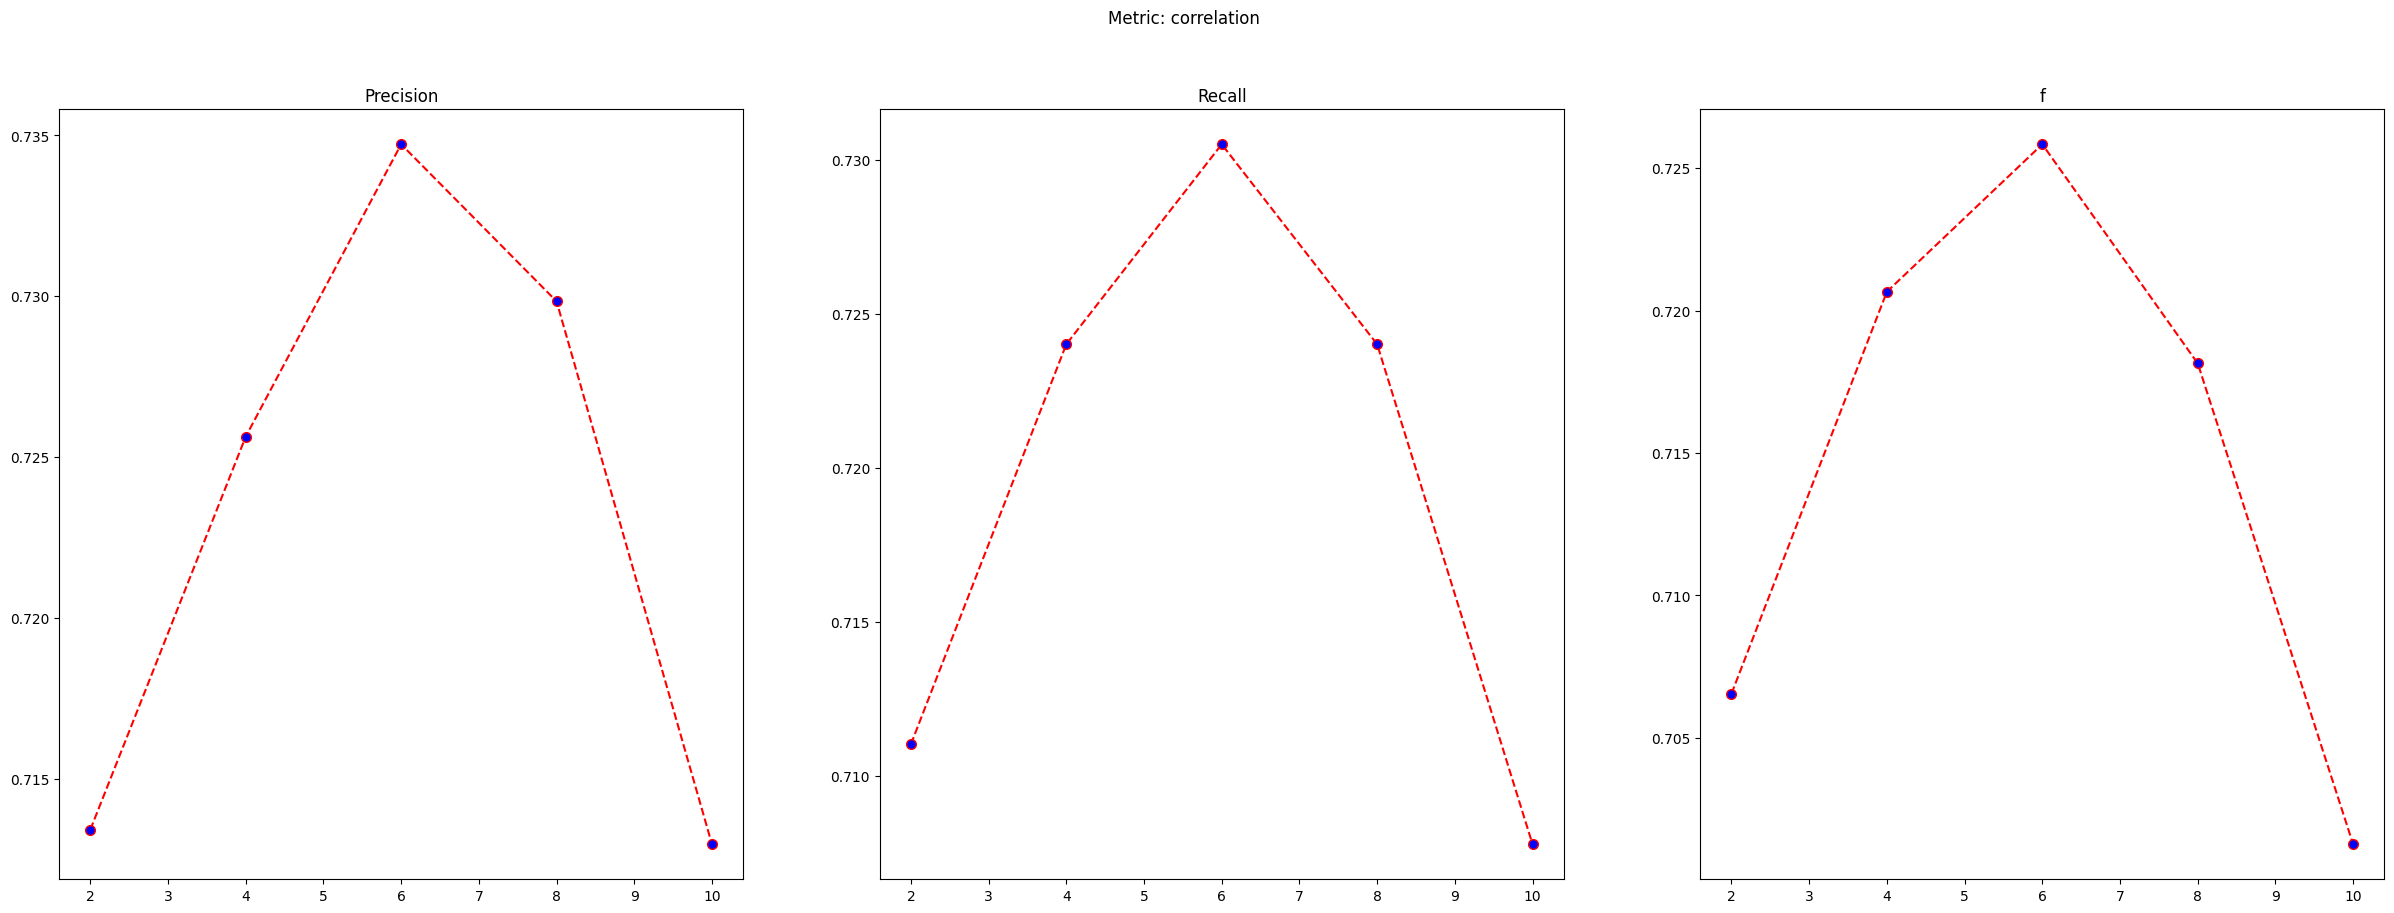

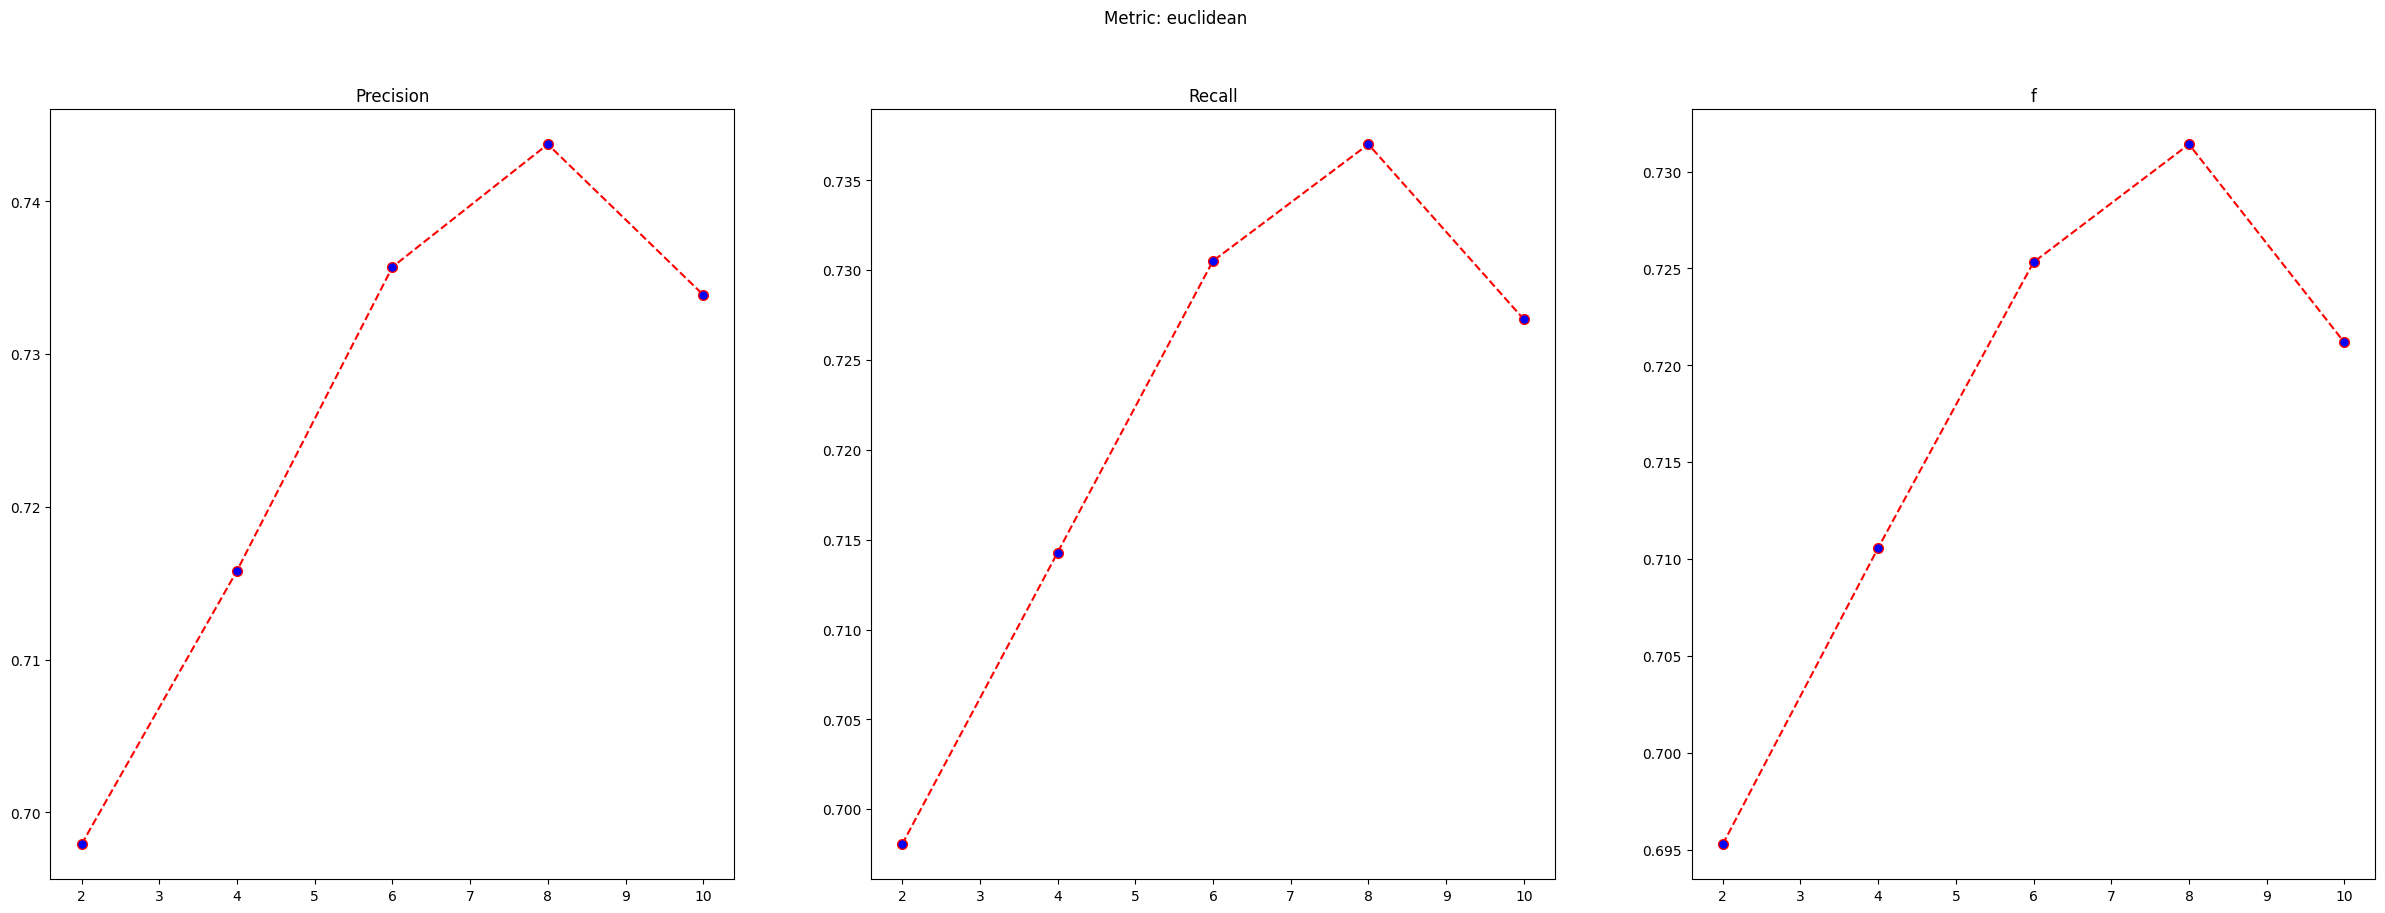

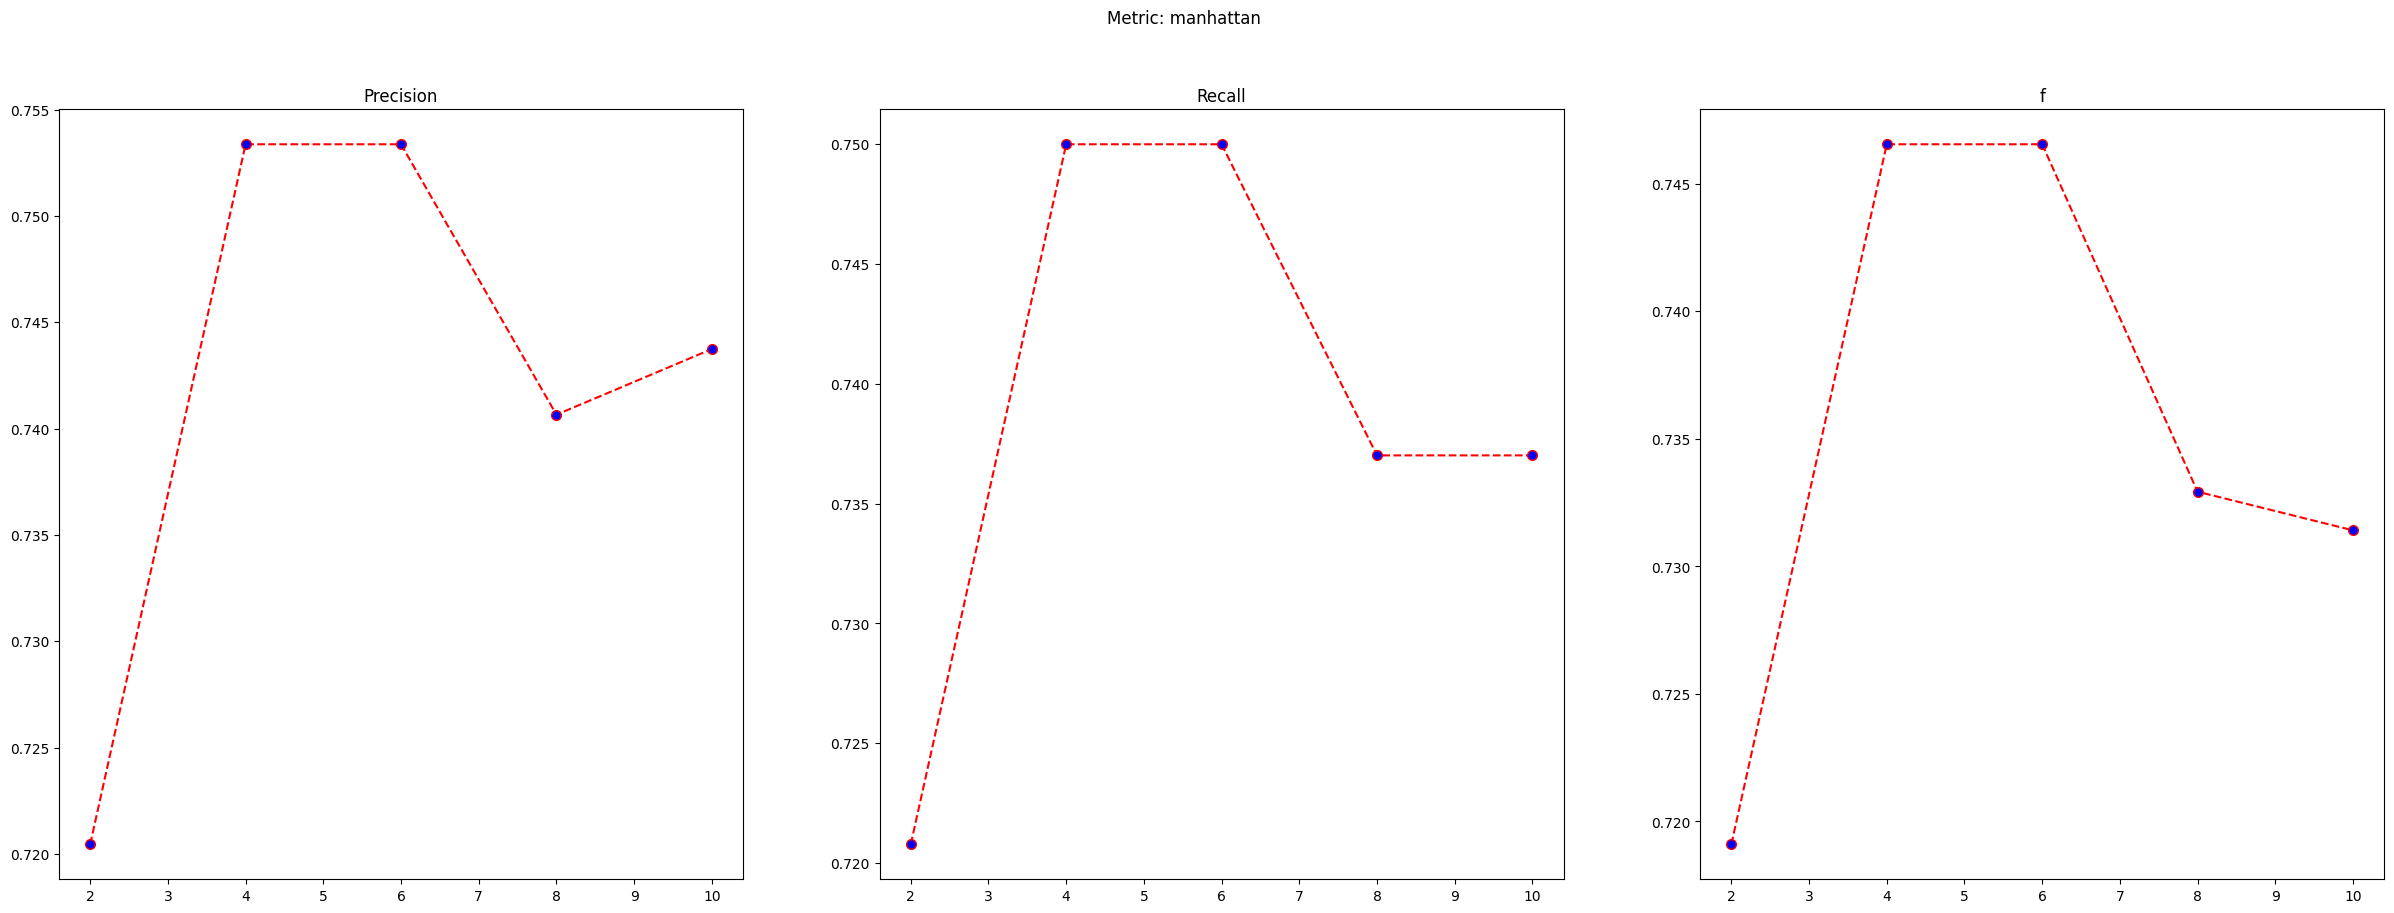

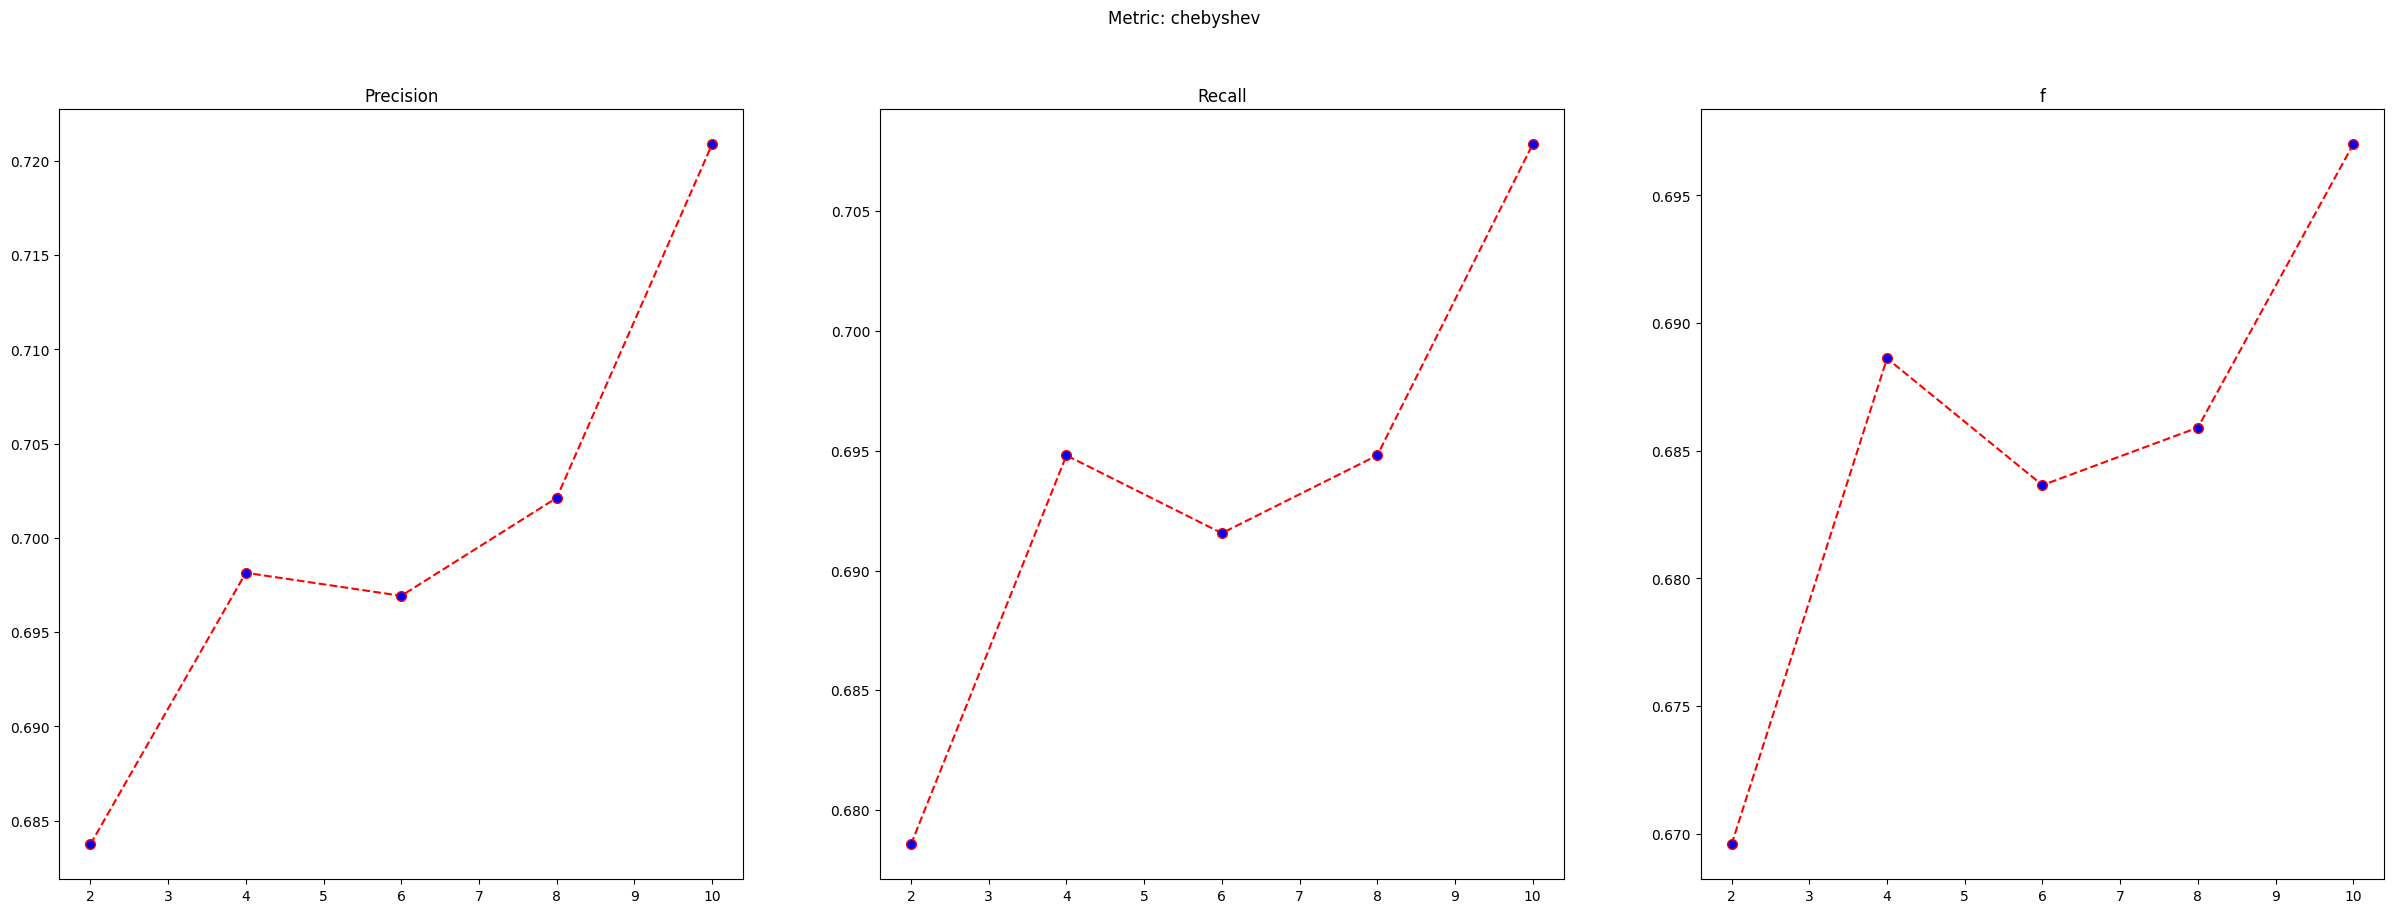

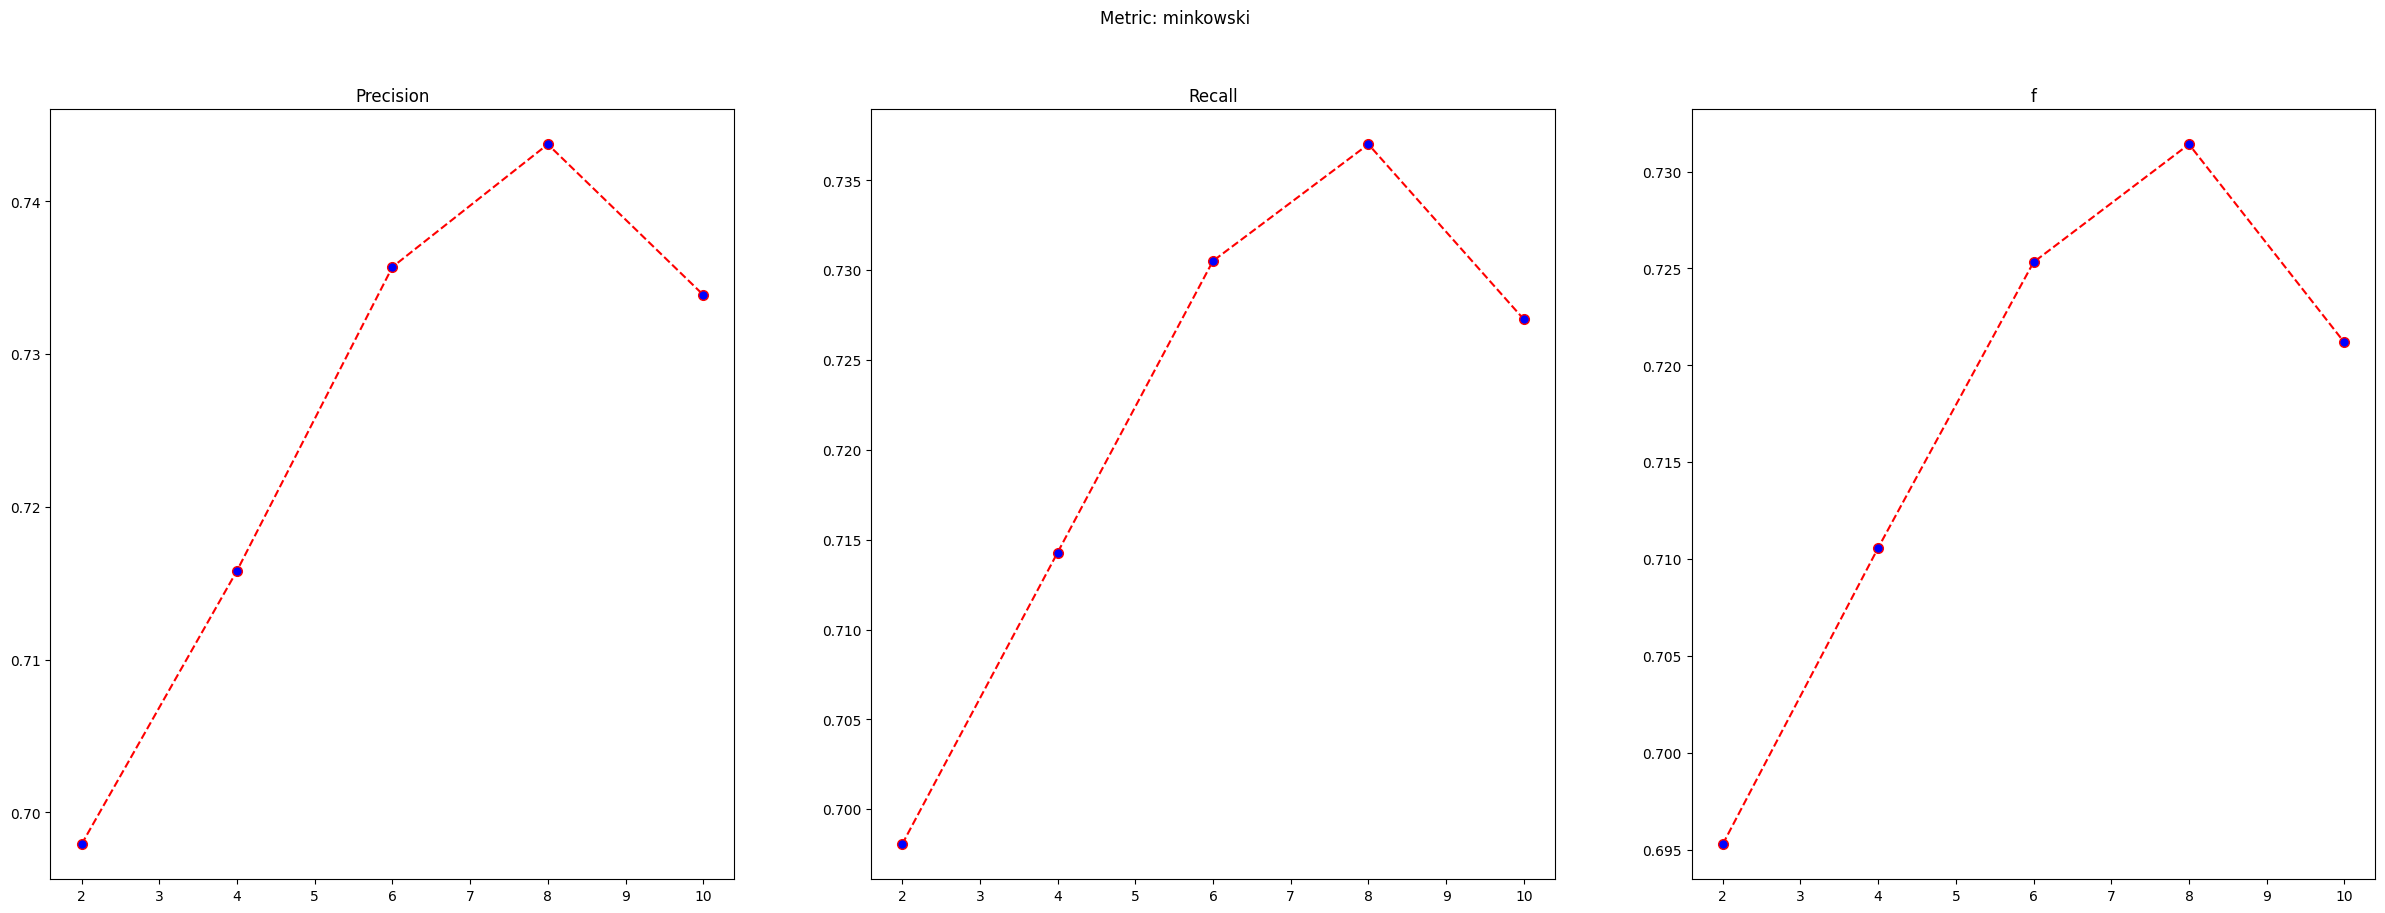

In [180]:
def doKNeightbors(m):
  precisionArr = []
  recallArr = []
  fArr = []

  neighborsRange = range(2, 12, 2)

  for i in neighborsRange:
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric=m)
    knn.fit(xTraining, yTraining)
    predict = knn.predict(xTest).tolist()

    metricsData = precision_recall_fscore_support(yTest, predict, average='weighted')

    precisionArr.append(np.average(metricsData[0]))
    recallArr.append(np.average(metricsData[1]))
    fArr.append(np.average(metricsData[2]))

  fig, ax = plt.subplots(1, 3, figsize=(30, 10))
  ax[0].plot(neighborsRange, precisionArr, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=7)
  ax[1].plot(neighborsRange, recallArr, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=7)
  ax[2].plot(neighborsRange, fArr, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=7)

  ax[0].set_title("Precision")
  ax[1].set_title("Recall")
  ax[2].set_title("f")

  fig.suptitle("Metric: " + m)

for m in ["correlation", "euclidean", "manhattan", "chebyshev", "minkowski"]:
  doKNeightbors(m)

plt.show()

### 2.3. Confusion Matrix

In [181]:
gender = df["GENDER"].unique()
gender.sort()
print(gender)

[0 1]


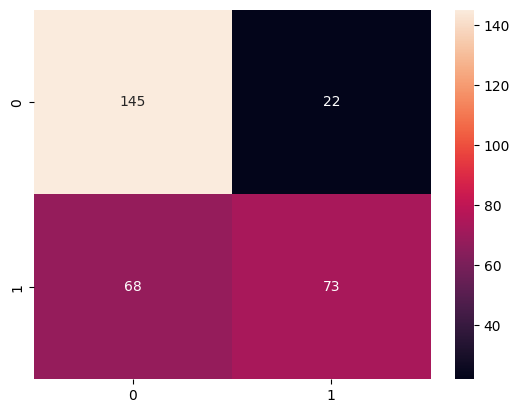

In [182]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='chebyshev')
knn.fit(xTraining, yTraining)
predictions = knn.predict(xTest).tolist()

confusionMatrix = confusion_matrix(yTest, predictions)
cm = pd.DataFrame(confusionMatrix, columns=gender, index = gender)
                  
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### 2.4. Метрики

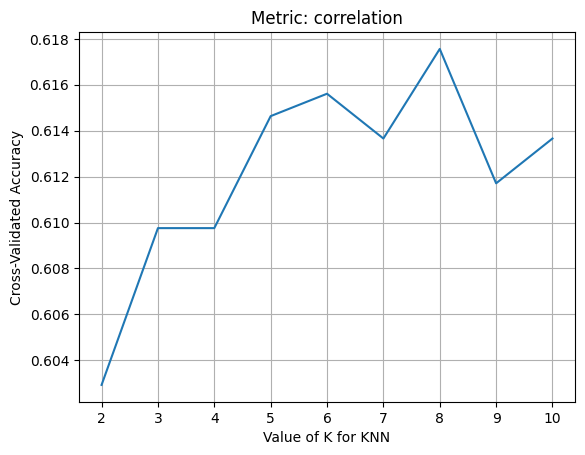

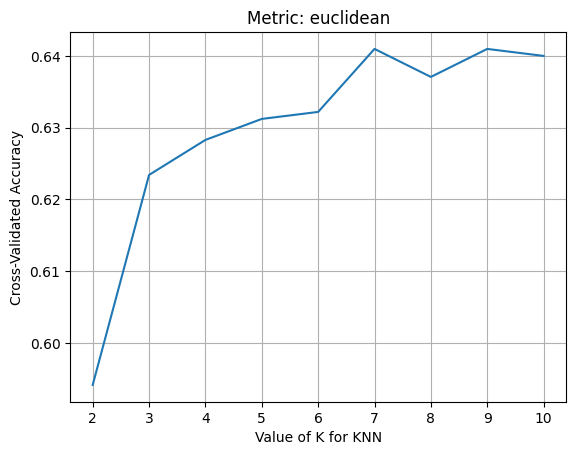

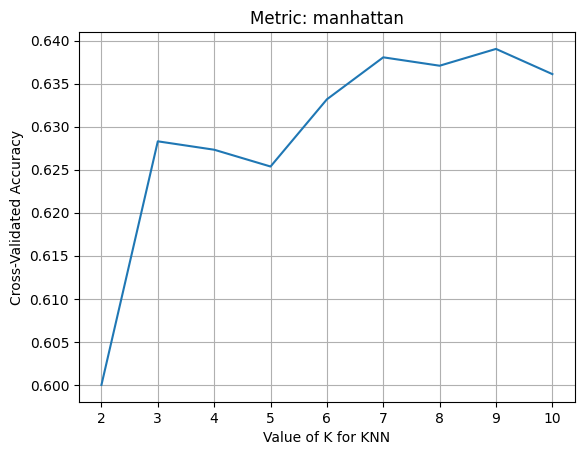

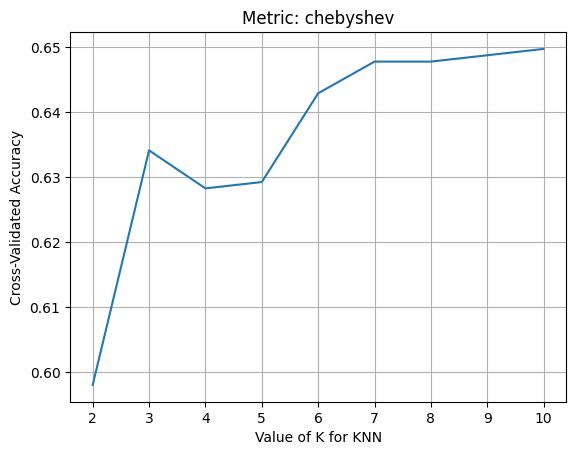

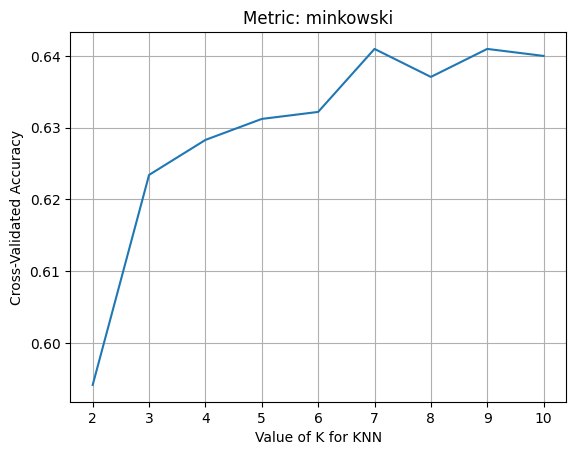

In [184]:
def doKNeightbors(m):
  kScores = []

  neighborsRange = range(2, 11)

  for i in neighborsRange:
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric=m)
    kScores.append(cross_val_score(knn, df, y, cv=5, scoring='accuracy').mean())

  plt.plot(neighborsRange, kScores)
  plt.title("Metric: " + m)
  plt.xlabel('Value of K for KNN')
  plt.ylabel('Cross-Validated Accuracy')
  plt.grid()
  plt.show()

for m in ["correlation", "euclidean", "manhattan", "chebyshev", "minkowski"]:
  doKNeightbors(m)

### 2.5. Деревья принятия решений

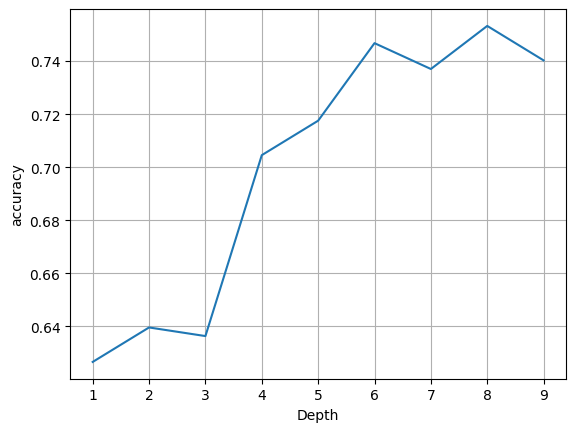

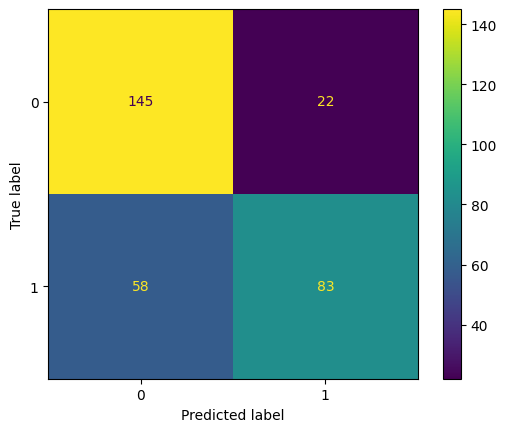

Max deep:  8
f1:  0.7338903680367096
Recall:  0.7402597402597403
Precision:  0.749165120593692


In [185]:
pltx = []
plty = []

for depth in range(1, 10):
    model = RandomForestClassifier(max_depth = depth).fit(xTraining, yTraining)
    predictions = model.predict(xTest)
    plty.append(accuracy_score(yTest, predictions))
    pltx.append(depth)

plt.plot(pltx, plty)
plt.xlabel('Depth')
plt.ylabel('accuracy')
plt.grid()
plt.show()

maxDepth = pltx[plty.index(max(plty))]
# pl = plot_confusion_matrix(model, xTest, yTest)
ConfusionMatrixDisplay.from_estimator(estimator=model, X=xTest, y=yTest)
plt.show()

print("Max deep: ", maxDepth)
print("f1: ", f1_score(yTest, predictions, average='weighted'))
print("Recall: ", recall_score(yTest, predictions, average='weighted'))
print("Precision: ", precision_score(yTest, predictions, average='weighted'))

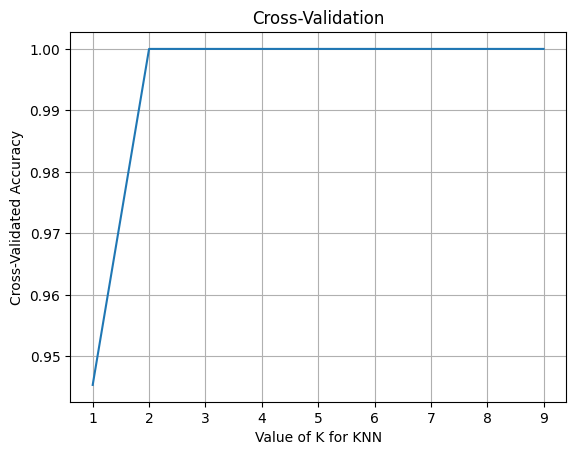

In [186]:
kScores = []
depthRange = range(1, 10)
for depth in depthRange:
  model = RandomForestClassifier(max_depth = depth).fit(xTraining, yTraining)
  kScores.append(cross_val_score(model, df, y, cv=5, scoring='accuracy').mean())

plt.plot(depthRange, kScores)
plt.title("Cross-Validation")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()